
# Machine Learning Internship task

Welcome folks, Thank you for applying for this internship and we are super excited to take this conversation ahead with you.

But before we go ahead, we would like you to go thru a small assessment, which will help us to evaluate you better on technical skills and working styles.


## Task Objective :
* [ ] Perform EDA on the given [data](https://github.com/geniusai-research/interns_task/blob/main/taskdata.csv).
* [ ] Build some new features which makes sense for the learning objective.
* [ ] Train any classifier (can be any model of your choice XGB,DNNs, etc) 
* [ ] Implement SHAP on this model to explain the decisions. (`Bonus points`) 
* [ ] Submit the task by creating a PR request on this [repository](https://github.com/geniusai-research/interns_task/).

## Instructions :
* Perform all the tasks mentioned above.
* Maintain a single **JupyterNotebook** which has all the descriptions and code in it. 
* Notebook needs to be properly structured .
* Code needs to reproducible.

**We will only accept the assignment if its in a single Notebook or else it will be rejected.**

## Important dates
The assignments needs to be completed in 1 week from today. <br>
**Deadline : 28th October**


If you have any issue then feel free to create issue on this [repository](https://github.com/geniusai-research/interns_task/) or reachout to us over the internshala chat.

<hr>

Cheers!!!  <br>
RK 


In [125]:
!pip install shap
!pip install mljar-supervised
!pip install xgboost
!pip install lightgbm

import shap
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.models import Sequential
from supervised.automl import AutoML
from sklearn.metrics import log_loss
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier
import warnings
warnings.simplefilter('ignore')

In [96]:
train = pd.read_csv("taskdata.csv")
train.head()

,user_id,account_id,max_return_days,average_return_days,customer_since_months,total_revenue,average_revenue,avg_vas_count,avg_used_vas_value,business_type,avg_wallet_bonus,avg_active_ads,avg_new_ads,avg_email_replies,avg_call_replies,avg_sms_replies,target
0,410039,496.0,8,1.500000,14,0.0,0.0,3.666667,66.666667,0,300.0,79.333333,15.250000,32.416667,27.916667,0.250000,0
1,410240,499.0,37,8.200000,10,0.0,0.0,4.900000,114.000000,0,0.0,232.100000,18.300000,16.200000,13.800000,0.000000,0
2,411764,493.0,9,1.533333,15,0.0,0.0,5.333333,106.666667,0,150.0,55.083333,3.750000,20.250000,24.500000,0.000000,0
3,411985,262.0,1,1.000000,14,0.0,0.0,6.307692,176.153846,0,1481.0,409.538462,80.769231,87.461538,57.615385,0.000000,1
4,412071,496.0,1,1.000000,18,0.0,0.0,5.846154,109.230769,0,41.5,48.230769,1.692308,17.461538,25.769231,0.230769,0


In [97]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4407 entries, 0 to 4406
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                4407 non-null   int64  
 1   account_id             4400 non-null   float64
 2   max_return_days        4407 non-null   int64  
 3   average_return_days    4407 non-null   float64
 4   customer_since_months  4407 non-null   int64  
 5   total_revenue          4407 non-null   float64
 6   average_revenue        4407 non-null   float64
 7   avg_vas_count          4407 non-null   float64
 8   avg_used_vas_value     4407 non-null   float64
 9   business_type          4407 non-null   int64  
 10  avg_wallet_bonus       4407 non-null   float64
 11  avg_active_ads         4407 non-null   float64
 12  avg_new_ads            4407 non-null   float64
 13  avg_email_replies      4407 non-null   float64
 14  avg_call_replies       4407 non-null   float64
 15  avg_

**Handling missing value**

In [98]:
train.isnull().sum()

user_id                  0
account_id               7
max_return_days          0
average_return_days      0
customer_since_months    0
total_revenue            0
average_revenue          0
avg_vas_count            0
avg_used_vas_value       0
business_type            0
avg_wallet_bonus         0
avg_active_ads           0
avg_new_ads              0
avg_email_replies        0
avg_call_replies         0
avg_sms_replies          0
target                   0
dtype: int64

**Dropping Columns**

It is clear that **user_id** and **account_id** donot have any contibution here.

So we simply drop the columns.

In [99]:
del train['user_id']
del train['account_id']

In [100]:
train2 = train[[column for column in train if train[column].count() / len(train) >= 0.3]]
# del train2['Id']
print("List of dropped columns:", end=" ")
for c in train.columns:
    if c not in train2.columns:
        print(c, end=", ")
print('\n')

List of dropped columns: 



Now lets take a look at how the Target attribute is distributed

count    4407.000000
mean        0.103245
std         0.304313
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: target, dtype: float64


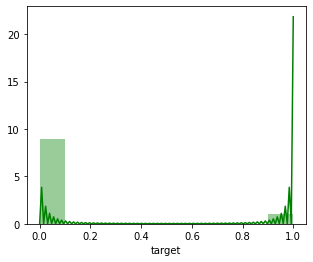

In [101]:
print(train['target'].describe())
plt.figure(figsize=(5, 4))
sns.distplot(train['target'], color='g', bins=10, hist_kws={'alpha': 0.4});

## **Numerical data distribution**

For this part lets look at the distribution of all of the features by ploting them

To do so lets first list all the types of our data from our dataset and take only the numerical ones:

In [102]:
list(set(train.dtypes.tolist()))

[dtype('int64'), dtype('float64')]

In [103]:
train_num = train.select_dtypes(include = ['float64', 'int64'])
train_num.head()

,max_return_days,average_return_days,customer_since_months,total_revenue,average_revenue,avg_vas_count,avg_used_vas_value,business_type,avg_wallet_bonus,avg_active_ads,avg_new_ads,avg_email_replies,avg_call_replies,avg_sms_replies,target
0,8,1.500000,14,0.0,0.0,3.666667,66.666667,0,300.0,79.333333,15.250000,32.416667,27.916667,0.250000,0
1,37,8.200000,10,0.0,0.0,4.900000,114.000000,0,0.0,232.100000,18.300000,16.200000,13.800000,0.000000,0
2,9,1.533333,15,0.0,0.0,5.333333,106.666667,0,150.0,55.083333,3.750000,20.250000,24.500000,0.000000,0
3,1,1.000000,14,0.0,0.0,6.307692,176.153846,0,1481.0,409.538462,80.769231,87.461538,57.615385,0.000000,1
4,1,1.000000,18,0.0,0.0,5.846154,109.230769,0,41.5,48.230769,1.692308,17.461538,25.769231,0.230769,0


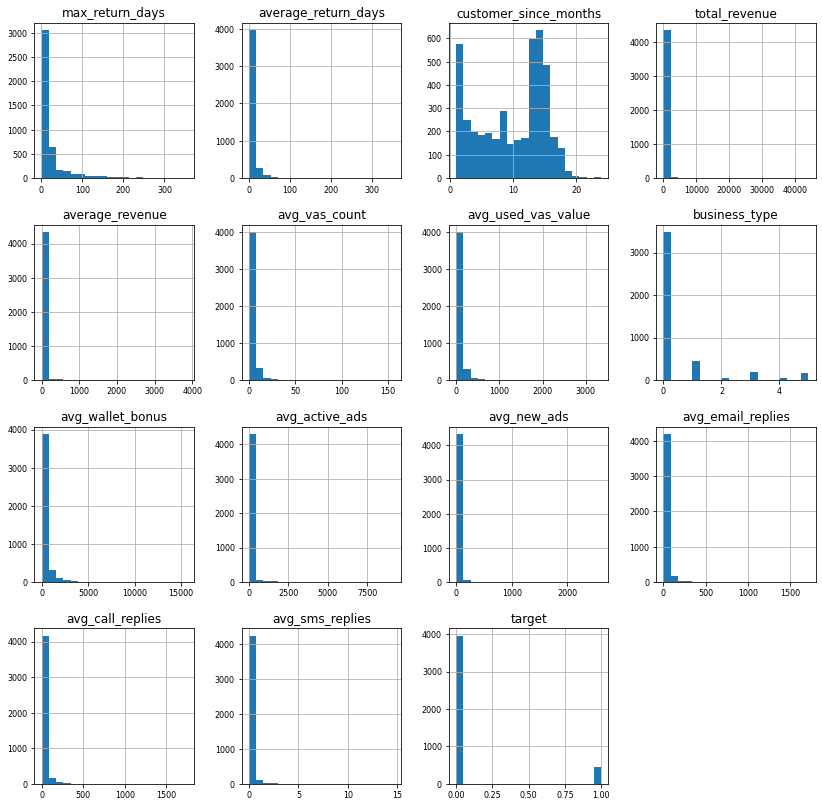

In [104]:
train_num.hist(figsize=(14, 14), bins=20, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

# **Correlation**

Now we'll try to find which features are strongly correlated with target. We'll store them in a var called golden_features_list. We'll reuse our train_num dataset to do so.

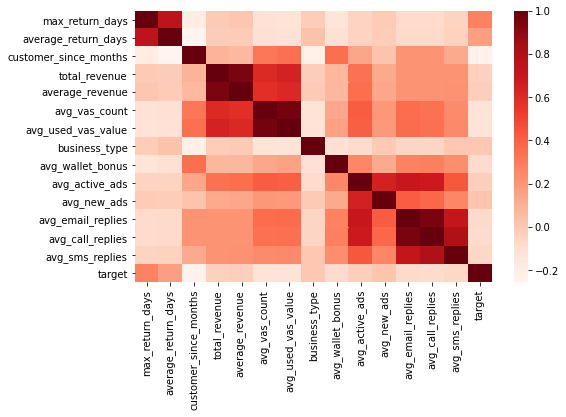

In [105]:
#Using Pearson Correlation

plt.figure(figsize=(8,5))
cor = train.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

In [106]:
#Correlation with output variable
cor_target = abs(cor["target"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.03]
print(relevant_features.sort_values())

total_revenue            0.032571
avg_sms_replies          0.062312
avg_email_replies        0.070729
avg_call_replies         0.075268
avg_wallet_bonus         0.076814
avg_vas_count            0.117167
avg_used_vas_value       0.128469
average_return_days      0.165715
customer_since_months    0.234972
max_return_days          0.275005
target                   1.000000
Name: target, dtype: float64


In [107]:
train_num_corr = train_num.corr()['target'][:-1] # -1 because the latest row is target
golden_features_list = train_num_corr[abs(train_num_corr) >= 0.03].sort_values(ascending=True)
print("There is {} strongly correlated values with target:\n{}".format(len(golden_features_list), golden_features_list))

There is 10 strongly correlated values with target:
customer_since_months   -0.234972
avg_used_vas_value      -0.128469
avg_vas_count           -0.117167
avg_wallet_bonus        -0.076814
avg_call_replies        -0.075268
avg_email_replies       -0.070729
avg_sms_replies         -0.062312
total_revenue           -0.032571
average_return_days      0.165715
max_return_days          0.275005
Name: target, dtype: float64


Perfect, we now have a list of strongly correlated values but this list is incomplete as we know that correlation is affected by outliers. So we could proceed as follow:

Plot the numerical features and see which ones have very few or explainable outliers
Remove the outliers from these features and see which one can have a good correlation without their outliers
Btw, correlation by itself does not always explain the relationship between data so ploting them could even lead us to new insights and in the same manner, check that our correlated values have a linear relationship to the Target.

For example, relationships such as curvilinear relationship cannot be guessed just by looking at the correlation value so lets take the features we excluded from our correlation table and plot them to see if they show some kind of pattern.

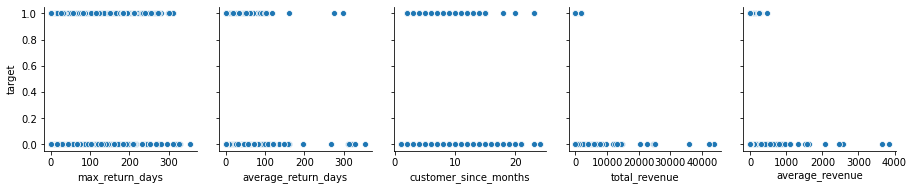

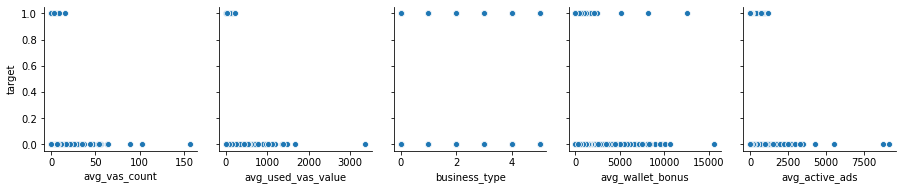

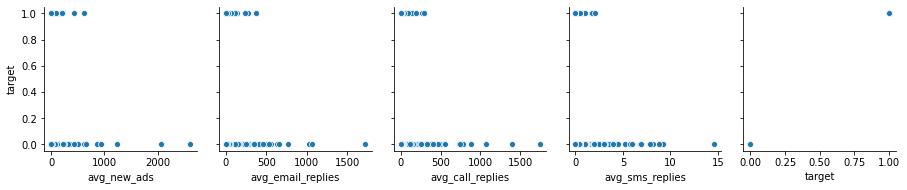

In [108]:
for i in range(0, len(train_num.columns), 5):
    sns.pairplot(data=train_num,
                x_vars=train_num.columns[i:i+5],
                y_vars=['target'])



## **Normalizing and Scalling**

In [109]:
train_scale = train_num.copy()
std_scale = StandardScaler()
for col in train_num[relevant_features.index].columns :
  if col!="target":
    train_scale[col] = std_scale.fit_transform(train_num[[col]])
  # print(train_num[col])
train_scale[relevant_features.index]

,max_return_days,average_return_days,customer_since_months,total_revenue,avg_vas_count,avg_used_vas_value,avg_wallet_bonus,avg_email_replies,avg_call_replies,avg_sms_replies,target
0,-0.328902,-0.295288,0.798200,-0.125392,0.075741,-0.046599,-0.046716,0.121763,0.004823,0.169988,0
1,0.336445,0.053544,0.024363,-0.125392,0.299608,0.357938,-0.407443,-0.171391,-0.226362,-0.312979,0
2,-0.305959,-0.293553,0.991659,-0.125392,0.378263,0.295263,-0.227079,-0.098178,-0.051131,-0.312979,0
3,-0.489502,-0.321321,0.798200,-0.125392,0.555122,0.889139,1.373350,1.116826,0.491193,-0.312979,1
4,-0.489502,-0.321321,1.572036,-0.125392,0.471347,0.317178,-0.357543,-0.148586,-0.030345,0.132836,0
...,...,...,...,...,...,...,...,...,...,...,...
4402,-0.489502,-0.321321,-1.136391,-0.125392,-0.589807,-0.616369,-0.407443,-0.289496,-0.212169,0.330976,0
4403,-0.489502,-0.321321,-1.523309,-0.125392,-0.589807,-0.616369,-0.407443,-0.301548,-0.264029,-0.312979,0
4404,-0.489502,-0.321321,-1.523309,-0.125392,-0.589807,-0.616369,-0.407443,-0.464244,-0.452362,-0.312979,0
4405,-0.489502,-0.321321,-1.523309,0.230631,0.680785,-0.018110,-0.407443,-0.283471,-0.321348,-0.312979,0


## **Classifiers**

In [110]:
X = train_scale.iloc[:,:-1]
y = train_scale.iloc[:,-1]
X = np.array(X)
y = np.array(y)

X = pd.DataFrame(X)
X.columns = train_scale.columns[:-1]
y = pd.DataFrame(y)
x_train,  x_test,y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

**Sk-learn Classifiers**

In [111]:
def cross_valid(model,train,features,target,cv):
    results = cross_val_predict(model, train[features], train[target], method="predict_proba",cv=cv)
    return metric(train[target],results)

def metric(y,y0):
    return log_loss(y,y0)

In [112]:
models = [lgb.LGBMClassifier(), xgb.XGBClassifier(), GradientBoostingClassifier(), LogisticRegression(), 
              RandomForestClassifier(), AdaBoostClassifier()
             ]

error_dict={}
for i in models:
    model = i
    error = cross_valid(model,train_scale,train_scale.columns,"target",cv=10)
    print(str(model).split("(")[0], error)
    error_dict[str(model).split("(")[0]]=error

LGBMClassifier 7.857056193002164e-06
XGBClassifier 0.0004956636585690173
GradientBoostingClassifier 7.857056424706368e-06
LogisticRegression 0.009747410189587488
RandomForestClassifier 0.016716755810005608
AdaBoostClassifier 9.992007221626415e-16


In [113]:
#@title
{k: v for k, v in sorted(error_dict.items(), key=lambda item: item[1])}

{'AdaBoostClassifier': 9.992007221626415e-16,
 'GradientBoostingClassifier': 7.857056424706368e-06,
 'LGBMClassifier': 7.857056193002164e-06,
 'LogisticRegression': 0.009747410189587488,
 'RandomForestClassifier': 0.016716755810005608,
 'XGBClassifier': 0.0004956636585690173}

**Auto-ML for ensembling top models**

In [114]:
automl = AutoML(algorithms=["Xgboost", "Random Forest","Decision Tree"],
                total_time_limit=60)
automl.fit(x_train, y_train)

AutoML directory: AutoML_4
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Xgboost', 'Random Forest', 'Decision Tree']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 1 model
1_DecisionTree logloss 0.272425 trained in 5.04 seconds
* Step default_algorithms will try to check up to 2 models
2_Default_RandomForest logloss 0.237554 trained in 8.36 seconds
3_Default_Xgboost logloss 0.233278 trained in 4.42 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.229879 trained in 0.44 seconds
AutoML fit time: 22.29 seconds


AutoML(algorithms=['Xgboost', 'Random Forest', 'Decision Tree'],
       total_time_limit=60)

**Neural Networks for Classification**

In [127]:
# Classifier architecture
classifier = Sequential()
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 14))
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.summary()

#Early Stopping

es = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=3)

# Fitting the ANN to the Training set
classifier.fit(x_train, y_train,validation_data=(x_test,y_test), epochs = 50,verbose = 1,callbacks=[es])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 6)                 90        
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 7         
Total params: 139
Trainable params: 139
Non-trainable params: 0
_________________________________________________________________
Train on 2952 samples, validate on 1455 samples
Epoch 1/50
2952/2952 [==============================] - 0s 133us/step - loss: 0.6129 - accuracy: 0.8896 - val_loss: 0.4847 - val_accuracy: 0.8900
Epoch 2/50
2952/2952 [==============================] - 0s 97us/step - loss: 0.4715 - accuracy: 0.9001 - val_loss: 0.4492 - val_accuracy: 0.8900
Epoch 3/50
2952/2952 [=========================

In [116]:
score, acc = classifier.evaluate(x_test, y_test)
print('Train score:', score)
print('Train accuracy:', acc)

1455/1455 [==============================] - 0s 42us/step
Train score: 0.3141653300150973
Train accuracy: 0.8900343775749207


# **Comparing Different Models**

**Neural Network Classifier**

In [117]:
# Predicting the Test set results
y_pred = classifier.predict(x_test)
y_pred = (y_pred > 0.5)

print('*'*20)
score, acc = classifier.evaluate(x_test, y_test)
print('Train score:', score)
print('Train accuracy:', acc)

# Making the Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
cm

********************
1455/1455 [==============================] - 0s 47us/step
Train score: 0.3141653300150973
Train accuracy: 0.8900343775749207


array([[1295,    0],
       [ 160,    0]])

**XGB Classifier**

In [118]:

xgb_mod = xgb.XGBClassifier().fit(x_train,y_train)
y_pred = xgb_mod.predict(x_test)
y_pred = (y_pred > 0.5)

print('*'*20)
score = xgb_mod.score(x_test, y_test)
print('Train score:', score)


# Making the Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
cm

********************
Train score: 0.8982817869415808


array([[1265,   30],
       [ 118,   42]])

**AutoML Enssemble**

In [119]:
y_pred =automl.predict(x_test)
# y_pred = (y_pred > 0.5)

print('*'*20)
score= automl.score (x_test, y_test)
print('Train score:', score)

# Making the Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
cm

********************
Train score: 0.8941580756013746


array([[1284,   11],
       [ 143,   17]])

We can clearly see that here **XGBoost Classifier** outperform all other algorithms. So we select it as the final model.

# **SHAP (SHapley Additive exPlanations)** 
It is a game theoretic approach to explain the output of any machine learning model. 

In [120]:
# load JS visualization code to notebook
shap.initjs()
final_model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])



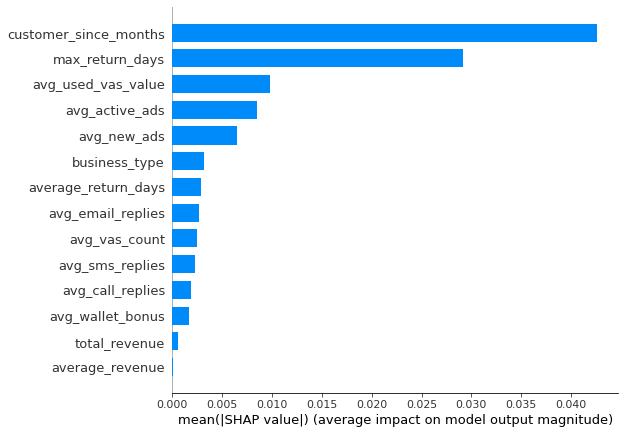

In [121]:
shap.summary_plot(shap_values, X, plot_type="bar")

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). 

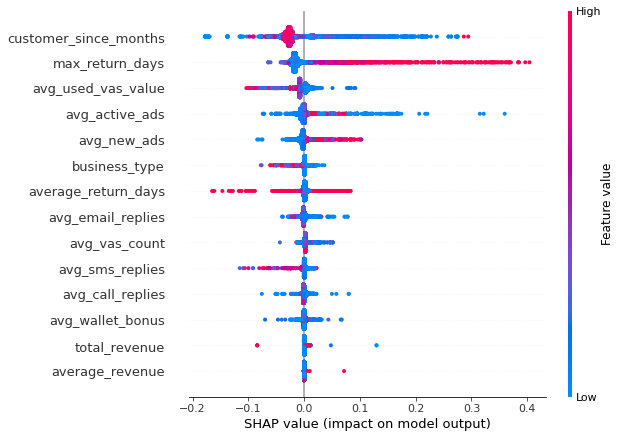

In [122]:
shap.summary_plot(shap_values, X)